In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import special

def background_cdf(x, N, var):
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N)

def background_cdf_awk(x, n_signal, n_sample, var):
    
    N = n_sample - ak.to_numpy(n_signal)
    
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N[:, np.newaxis])

def rician_pdf(x, var, loc_val):
    
    x = x[np.newaxis, :]
    loc_val = loc_val[:, np.newaxis]
    
    return x * np.exp( -1 * (x ** 2 + loc_val ** 2) / var ) * special.iv(0, x * 2 * loc_val / var)

def cdf_from_pdf(x, pdf):
    
    cdf = np.zeros((pdf.shape[0], x.size))
    for i in range(x.size):
        
        cdf[:, i] = np.trapz(pdf[:, 0:i+1], x[0:i+1], axis=-1)
        
    return cdf

def combine_batch_cdf(cdf, counts):
    
    count = 0
    cdf_ak = []
    for n in counts:
        cdf_ak.append(cdf[count:count+n, :])
        count+=n
    cdf_ak = ak.Array(cdf_ak)
        
    return ak.to_numpy(ak.prod(cdf_ak, axis=1))

def get_spectra_peaks(freq_spectra, threshold):
    
    peaks = []
    for i in range(freq_spectra.shape[0]):
        i_peak_inds = np.where(abs(freq_spectra[i, :]) > threshold)[0]
        i_peaks = abs(freq_spectra[i, i_peak_inds])

        peaks.append(list(i_peaks))
    
    return ak.Array(peaks)
    
def generate_signal_cdf(peaks, x, var, n_sample, batchsize=1000):
    
    peak_counts = ak.num(peaks, axis=1)
    num_spectra = ak.num(peaks, axis=0)
    
    spectra_inds = np.arange(0, num_spectra, 1)
    combined_cdf = np.zeros((num_spectra, x.size))
    
    for i, spectra_batch in enumerate(np.array_split(spectra_inds, num_spectra//batchsize)):
        
        batch_peaks = peaks[spectra_batch]
        batch_counts = ak.num(batch_peaks, axis=1)
        flat_batch_peaks = ak.to_numpy(ak.flatten(batch_peaks))
        
        batch_pdf = rician_pdf(x, var, flat_batch_peaks)
        batch_norm = 1/np.trapz(batch_pdf, x, axis=-1)
        batch_pdf = batch_norm[:, np.newaxis] * batch_pdf
        
        batch_cdf = cdf_from_pdf(x, batch_pdf)
        batch_cdf = combine_batch_cdf(batch_cdf, batch_counts)

        combined_cdf[spectra_batch, :] = batch_cdf * background_cdf_awk(x, batch_counts, n_sample, var)
        
        if i % 5 == 4:
            print(f'{i + 1} / {num_spectra//batchsize}')
            
    return combined_cdf

# validate noise variance

In [2]:
R,Nch,kb,bw,Nsamp,T=50,60,1.38e-23,205e6,8192,10

# noise power
n_pwr = kb * T * bw

# noise variance single channel, time-domain (tau_1t)
tau_1t = n_pwr * R
# noise variance single channel, freq-domain (tau_1f)
tau_1f = tau_1t / Nsamp
# noise variance sixty channel sum, time-domain (tau_60t)
tau_60t = tau_1t * Nch
# noise variance sixty channel sum, freq-domain (tau_60f, this is the noise variance in the paper)
tau_60f = tau_60t / Nsamp

# single-channel complex wgn with total variance tau_1t
rng = np.random.default_rng()
noise_1t = rng.multivariate_normal([0,0], np.eye(2) * tau_1t/2, Nsamp) # variance is divided by two for correct total variance.
noise_1t = noise_1t[:,0] + 1j * noise_1t[:,1]

# sixty-channel complex wgn. each channel has total variance tau_1t
noise_60t = rng.multivariate_normal([0,0], np.eye(2) * tau_1t/2, Nsamp*Nch) # variance is divided by two for correct total variance.
noise_60t = noise_60t[:,0] + 1j * noise_60t[:,1]
noise_60t = noise_60t.reshape((Nch, Nsamp))

print('1 Channel, Time-domain')
print(f'The single-channel time-domain noise variance is --- {tau_1t}')
print(f'The single-channel time-domain sample variance is --- {np.mean(abs(noise_1t)**2)}\n')

noise_1f = np.fft.fft(noise_1t, norm='forward')

print('1 Channel, Freq-domain')
print(f'The single-channel freq-domain noise variance is --- {tau_1f}')
print(f'The single-channel freq-domain sample variance is --- {np.mean(abs(noise_1f)**2)}\n')


noise_60t_sum = noise_60t.sum(axis=0)

print('60 Channel sum, Time-domain')
print(f'The sixty-channel sum time-domain noise variance is --- {tau_60t}')
print(f'The sixty-channel sum time-domain sample variance is --- {np.mean(abs(noise_60t_sum)**2)}\n')

noise_60f_sum = np.fft.fft(noise_60t_sum, norm='forward')

print('60 Channel sum, Freq-domain')
print(f'The sixty-channel sum freq-domain noise variance is --- {tau_60f}')
print(f'The sixty-channel sum freq-domain sample variance is --- {np.mean(abs(noise_60f_sum)**2)}\n')

1 Channel, Time-domain
The single-channel time-domain noise variance is --- 1.4145e-12
The single-channel time-domain sample variance is --- 1.4308855976075308e-12

1 Channel, Freq-domain
The single-channel freq-domain noise variance is --- 1.7266845703125e-16
The single-channel freq-domain sample variance is --- 1.7466865205170054e-16

60 Channel sum, Time-domain
The sixty-channel sum time-domain noise variance is --- 8.487e-11
The sixty-channel sum time-domain sample variance is --- 8.532019984036066e-11

60 Channel sum, Freq-domain
The sixty-channel sum freq-domain noise variance is --- 1.0360107421875e-14
The sixty-channel sum freq-domain sample variance is --- 1.0415063457075276e-14



# check summed frequency spectrum power threshold noise distribution

In [3]:
sns.set_theme(context='paper', font_scale=1.25, style='whitegrid')

In [4]:
x = np.linspace(2e-7,5e-7, 1001)
ray_cdf = (1-np.exp(-(x**2)/tau_60f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])
#ray_pdf = ray_pdf/np.trapz(ray_pdf)

In [5]:
N = 100000

lots_of_noise = rng.multivariate_normal([0,0],np.eye(2)*tau_60f/2, N*Nsamp)
lots_of_noise = lots_of_noise[:,0] + 1j * lots_of_noise[:,1]
lots_of_noise = lots_of_noise.reshape(N, Nsamp)
lots_of_noise = np.max(abs(lots_of_noise),axis=1)


(2.5e-07, 4.5e-07)

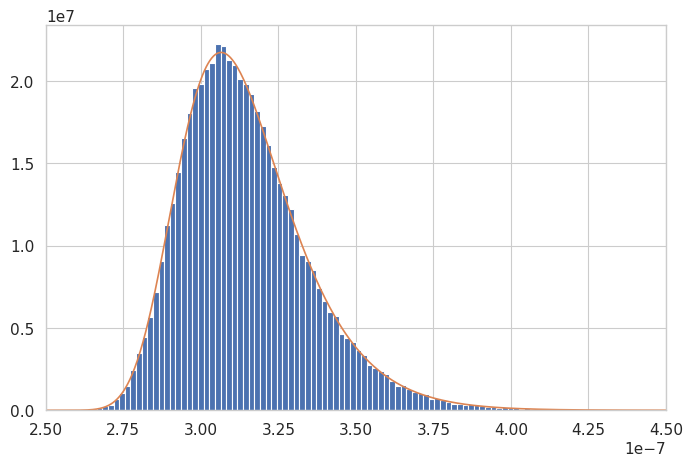

In [6]:

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()

hist = ax.hist(lots_of_noise,bins=100, density=True)
ax.plot(x,  ray_pdf)

ax.set_xlim(2.5e-7, 4.5e-7)


# check summed frequency spectrum power threshold signal distribution

In [79]:
N = 100000
scale_factor = 0.66

peaks = np.array(
    [5e-7-1j*5e-7,
     3e-7+1j*3e-7,
     3e-7-1j*3e-7,
     2e-7+1j*2e-7]) * scale_factor
peak_inds = np.array([2000, 2500, 3000, 3500])

lots_of_noise = rng.multivariate_normal([0,0],np.eye(2)*tau_60f/2, N*Nsamp)
lots_of_noise = lots_of_noise[:,0] + 1j * lots_of_noise[:,1]
lots_of_noise = lots_of_noise.reshape(N, Nsamp)
noise_maxima = np.max(abs(lots_of_noise),axis=1)

lots_of_noise[:, peak_inds] += peaks
signal_maxima = np.max(abs(lots_of_noise),axis=1)




## validate scipy rician

(0.0, 25000000.0)

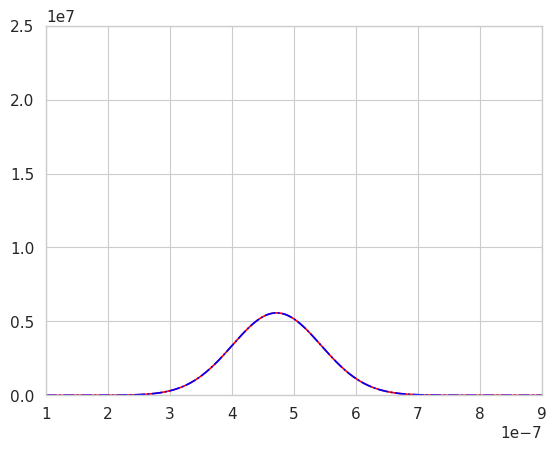

In [80]:
y = np.linspace(1e-7, 9e-7, 2001)

rice_pdf1 = 2*(y / tau_60f) * np.exp(-(y**2 + abs(peaks[0])**2)/(1*tau_60f))*special.i0(2*y*abs(peaks[0])/ tau_60f)
rice_pdf2 = stats.rice.pdf(y, abs(peaks[0])/np.sqrt(tau_60f/2), scale=np.sqrt(tau_60f/2))

plt.plot(y, rice_pdf1, color='red')
plt.plot(y, rice_pdf2, ls='-.', color='blue')

plt.xlim(1e-7, 9e-7)
plt.ylim(0, 2.5e7)

In [81]:
rice_cdf = np.ones(2001)
for peak in peaks:
    rice_cdf *= stats.rice.cdf(y, abs(peak)/np.sqrt(tau_60f/2), scale=np.sqrt(tau_60f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_60f)) ** (Nsamp-peaks.size)

signal_pdf = np.gradient(signal_cdf, y[1]-y[0])


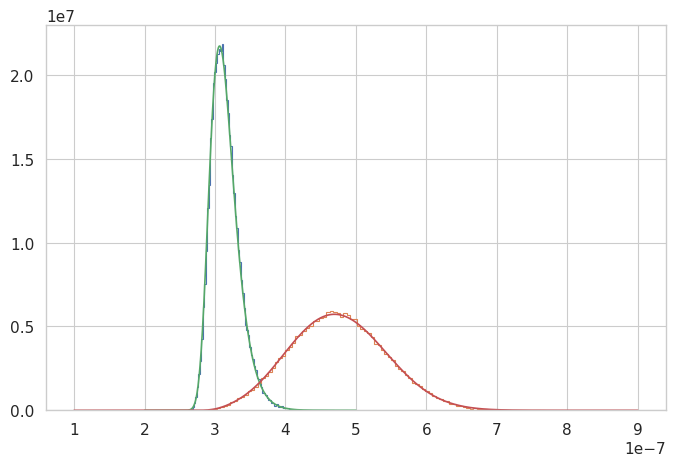

In [82]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

hist = ax.hist(noise_maxima, bins=100, density=True, histtype='step' )
hist = ax.hist(signal_maxima, bins=100, density=True, histtype='step')

ax.plot(x, ray_pdf)
ax.plot(y, signal_pdf)